In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision import transforms


In [2]:
# cosmetics
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['legend.fontsize'] = 22
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['figure.titlesize'] = 22
matplotlib.rcParams["axes.grid"] = True

In [3]:
rootf = 'data/seg_'

# Basic EDA

In [4]:
img_targetSize = (128, 128)
basetransforms = transforms.Compose([
    transforms.Resize(img_targetSize),
    transforms.ToTensor()
    # transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    #transforms.ToTensor()
])
traintransforms = transforms.Compose([
    transforms.Resize(img_targetSize),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])


In [5]:
classidxs = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

In [6]:
trainDataset = datasets.ImageFolder(root=rootf+'train/seg_train', transform=traintransforms)
valSplit = 0.2
trainDataset, valDataset = random_split(trainDataset, [int((1-valSplit)*len(trainDataset))+1, int(valSplit*len(trainDataset))])

trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True, num_workers=4)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False, num_workers=4) 
testDataset = datasets.ImageFolder(root=rootf+'test/seg_test', transform=basetransforms)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
class_names = trainDataset.dataset.classes
num_classes = len(class_names)
# Target-validation distribution is just too akward to plot

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Load batch of image
batch = next(iter(trainLoader))
images, labels = batch
images.shape

torch.Size([32, 3, 128, 128])

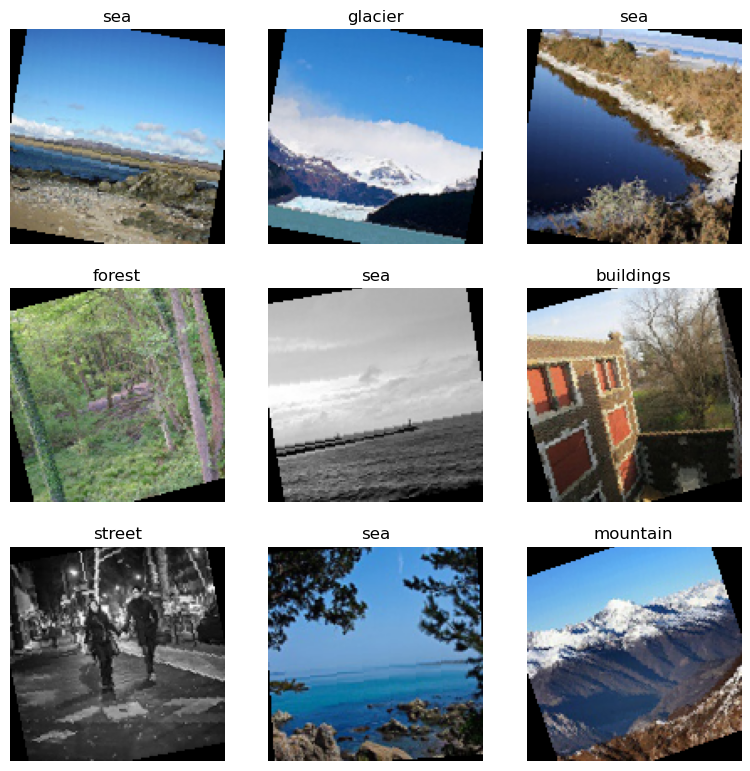

In [10]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(class_names[labels[i]],fontdict={'fontsize': 12})
plt.tight_layout()

In [11]:
@torch.no_grad()
def showImage(img,labels,model):
    figure = plt.figure(figsize=(8, 8))
    model.eval()
    img = img.to(device)
    pred = model(img)
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().numpy()
    pred = np.squeeze(pred)
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i].detach().cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(class_names[pred[i]]+f'\nTrue:{class_names[labels[i]]} ',fontdict={'fontsize': 12},color ='red' if pred[i] != labels[i] else 'green')

    plt.axis('off')
    return figure

# Creating model

In [12]:
class convBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1):
        super(convBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [13]:
# ConvBlock test
sambpleConvBlock = convBlock(3, 64)
tmp = sambpleConvBlock(images)
tmp.shape

torch.Size([32, 64, 64, 64])

In [14]:
class IntelModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(IntelModel,self).__init__()
        self.conv1 = convBlock(in_channels, 64)
        self.conv2 = convBlock(64, 128)
        self.conv3 = convBlock(128, 256)
        self.conv4 = convBlock(256, 512)
        self.flatten = nn.Flatten()
        multiplier = img_targetSize[0]//(2**4) # 2**4 maxpool size to the power of the number of maxpool layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512*multiplier*multiplier, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Model fitting

In [15]:
@torch.no_grad()
def plotConfusionMatrix(model,imgs,labels):
    model.eval()
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = model(imgs)
    preds = torch.argmax(preds, dim=1)
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    confusionMatrix = np.zeros((num_classes,num_classes))
    for t,p in zip(labels,preds):
        confusionMatrix[t,p] += 1
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(confusionMatrix, cmap='Blues')
    plt.xticks(np.arange(num_classes), class_names, rotation=90)
    plt.yticks(np.arange(num_classes), class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.colorbar()
    return figure

In [16]:
lossF = nn.CrossEntropyLoss()
model = IntelModel(3, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mymetrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


In [17]:
numEpochs = 10
trainSteps = len(trainLoader)
valSteps = len(valLoader)//valLoader.batch_size
writer = SummaryWriter()
writer.add_graph(model, images.to(device))

In [ ]:
for epoch in range(numEpochs):
    print('Epoch:', epoch)
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for trainingStep, (images, labels) in enumerate(trainLoader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = lossF(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        writer.add_scalar('Loss/train', loss, epoch*trainSteps+trainingStep)
        
        preds = torch.argmax(outputs, dim=1)
        train_acc = torch.sum(preds == labels).item()/batch[0].shape[0]
        writer.add_scalar('Accuracy/train', train_acc, epoch*trainSteps+trainingStep)
        
        confmx = plotConfusionMatrix(model,images,labels)
        writer.add_figure('Confusion Matrix/train', confmx, epoch*trainSteps+trainingStep)
        
        sampleImages = showImage(images,labels,model)
        writer.add_figure('Images/train', sampleImages, epoch*trainSteps+trainingStep)
        
        print(f'Training Step: {trainingStep}/{trainSteps} Loss: {loss.item()}, Accuracy:', train_acc, end='\r')
    print(f'Training Loss: {train_loss/trainSteps} Training Accuracy: {train_acc}')


Epoch: 0


# Evaluation